# Evaluate bias in attack and sideslip angles to get average  W to be 0, at flight scale, then averaged at the campaign scale

In [1]:
import sys
import os
from utils import *

/home/ljaffeux/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-05-30 09:25:56.450000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748589956.577099 1187360 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748589956.617180 1187360 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 09:25:56.902058: I tensorflow/core/platform/cpu_f

In [2]:
def objective(params, df):
    aoa_bias, aos_bias = params
    U,V,W = wind_computation_bias(df, aoa_bias*1e5, aos_bias*1e5) # 1e5 factor is required for easier convergence
    # Calculate the mean squared error between W and 0 (i.e., make W as close to zero as possible)
    mse = np.mean(W**2)
    return mse

def process_campaign_bias(campaign, INS, data_root='../../Data'):
    if not campaign == 'MAESTRO':
        INS=''
    segmentation_dir = f'{data_root}/Segmentation_default/{campaign}/{INS}'
    raw_data_dir = f'{data_root}/Raw'
    results = []
    
    
    if not os.path.exists(segmentation_dir):
        print(f"Segmentation directory not found: {segmentation_dir}")
        return None

    for fname in tqdm(os.listdir(segmentation_dir)):
        if not fname.endswith('.yaml'):
            continue

        flight_number = extract_flight_number(fname)
        if flight_number is None:
            continue

        try:
            yaml_path = os.path.join(segmentation_dir, fname)

            # Match raw data folder
            matching_raw_folder = [f for f in os.listdir(raw_data_dir)
                                   if os.path.isdir(os.path.join(raw_data_dir, f)) and campaign in f and INS in f]
            if not matching_raw_folder:
                print(f"❌ No raw folder found for {campaign} {INS}")
                continue

            raw_folder = os.path.join(data_root, 'Raw', matching_raw_folder[0])
            # Look for any .nc file containing the flight number
            flight_str = f'{flight_number:02d}'
            nc_candidates = [f for f in os.listdir(raw_folder)
                             if f.endswith('.nc') and flight_str in f]
            
            if not nc_candidates:
                print(f"❌ No matching .nc file found for flight {flight_number} in {raw_folder}")
                continue
            
            nc_path = os.path.join(raw_folder, nc_candidates[0])  # Use first match
            # print(f"  - Loading NetCDF: {nc_candidates[0]}")

            yaml_data = read_yaml(yaml_path)
            df_raw = load_raw_data(nc_path)
            if 'SIDESLIP_RAD' in df_raw.columns:
                df_raw['AOS_RAD'] = df_raw['SIDESLIP_RAD']
            
            # Segment mask
            df_prep = df_raw
            initial_guess = [0, 0]  # Start with 0° bias
            bounds = [(-1, 1), (-1, 1)] # max biases of +- 1°
            result = minimize(objective, initial_guess, args=(df_prep,), bounds=bounds, method='L-BFGS-B')
            aoa_bias, aos_bias = result.x
            results.append({
                'flight': flight_number,
                'aoa_bias': 1e5*aoa_bias , # account for the 1e5 factor in the objecive function
                'aos_bias': 1e5*aos_bias , # account for the 1e5 factor in the objecive function
            })
        except Exception as e:
            print(f"❌ Error in flight {flight_number}: {e}")

    return results

# Compute and Plot the results
uses all data (not only legs)
ignoring data from the first EUREC4A flights in the average computation (up to as200008)

In [3]:
results = process_campaign_bias('MAESTRO', 'IMU2', data_root='../Data')
df_biases_imu2 = pd.DataFrame(results)
results = process_campaign_bias('MAESTRO', 'IMU1', data_root='../Data')
df_biases_imu1 = pd.DataFrame(results)
results = process_campaign_bias('EUREC4A', '', data_root='../Data')
df_biases_eureca = pd.DataFrame(results)
results = process_campaign_bias('LIAISE', '', data_root='../Data')
df_biases_liaise = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:36<00:00, 12.06s/it]


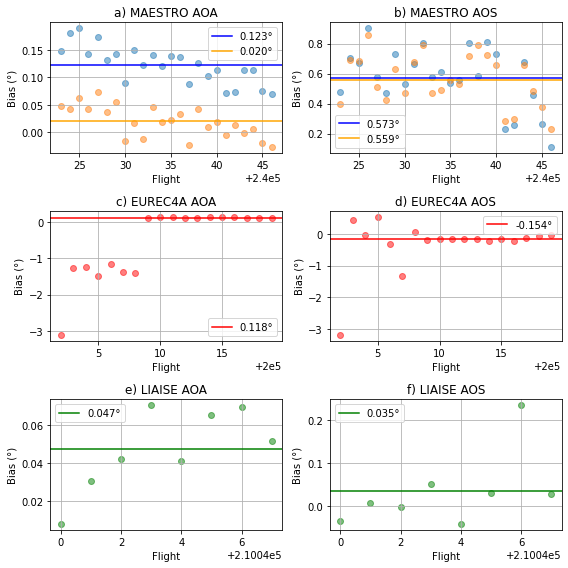

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=False)

# MAESTRO aoa
axs[0, 0].scatter(df_biases_imu1['flight'], -df_biases_imu1['aoa_bias'], alpha=0.5)
axs[0, 0].scatter(df_biases_imu1['flight'], -df_biases_imu2['aoa_bias'], alpha=0.5)
mean=-df_biases_imu1['aoa_bias'].mean()
axs[0, 0].axhline(y=mean , label=f'{mean:.03f}°', color='blue')
mean=-df_biases_imu2['aoa_bias'].mean()
axs[0, 0].axhline(y=mean , label=f'{mean:.03f}°', color='orange')
axs[0, 0].set_title('a) MAESTRO AOA')
axs[0, 0].grid()
axs[0, 0].legend()

# MAESTRO aos
axs[0, 1].scatter(df_biases_imu1['flight'], -df_biases_imu1['aos_bias'], alpha=0.5)
axs[0, 1].scatter(df_biases_imu1['flight'], -df_biases_imu2['aos_bias'], alpha=0.5)
mean=-df_biases_imu1['aos_bias'].mean()
axs[0, 1].axhline(y=mean , label=f'{mean:.03f}°', color='blue')
mean=-df_biases_imu2['aos_bias'].mean()
axs[0, 1].axhline(y=mean , label=f'{mean:.03f}°', color='orange')
axs[0, 1].set_title('b) MAESTRO AOS')
axs[0, 1].grid()
axs[0, 1].legend()

# EUREC4A aoa
axs[1, 0].scatter(df_biases_eureca['flight'], -df_biases_eureca['aoa_bias'], alpha=0.5, color='red')
mean=-df_biases_eureca[df_biases_eureca['flight']>200008]['aoa_bias'].mean()
axs[1, 0].axhline(y=mean , label=f'{mean:.03f}°', color='red')
axs[1, 0].set_title('c) EUREC4A AOA')
axs[1, 0].grid()
axs[1, 0].legend()

# EUREC4A aos
axs[1, 1].scatter(df_biases_eureca['flight'], -df_biases_eureca['aos_bias'], alpha=0.5, color='red')
mean=-df_biases_eureca[df_biases_eureca['flight']>200008]['aos_bias'].mean()
axs[1, 1].axhline(y=mean , label=f'{mean:.03f}°', color='red')
axs[1, 1].set_title('d) EUREC4A AOS')
axs[1, 1].grid()
axs[1, 1].legend()

# LIAISE aoa
axs[2, 0].scatter(df_biases_liaise['flight'], -df_biases_liaise['aoa_bias'], alpha=0.5, color='green')
mean=-df_biases_liaise['aoa_bias'].mean()
axs[2, 0].axhline(y=mean , label=f'{mean:.03f}°', color='green')
axs[2, 0].set_title('e) LIAISE AOA')
axs[2, 0].grid()
axs[2, 0].legend()

# LIAISE aos
axs[2, 1].scatter(df_biases_liaise['flight'], -df_biases_liaise['aos_bias'], alpha=0.5, color='green')
mean=-df_biases_liaise['aos_bias'].mean()
axs[2, 1].axhline(y=mean , label=f'{mean:.03f}°', color='green')
axs[2, 1].set_title('f) LIAISE AOS')
axs[2, 1].grid()
axs[2, 1].legend()

# General layout tweaks
for ax in axs.flat:
    ax.set_xlabel('Flight')
    ax.set_ylabel('Bias (°)')
plt.tight_layout()
plt.savefig('../Plots/bias_estimation_PO.png')